In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50

In [3]:
# load data
df = pd.read_csv("Data_Marketing_Customer_Analysis_Round3.csv")
# create dataframes with numerical...
df_num = df[df.select_dtypes(include=[np.number]).columns].drop("total_claim_amount", axis=1)
# ...and categorical data only
df_cat = df[df.select_dtypes(include=[object]).columns].drop("effective_to_date", axis=1)

# 0. Data Exploration

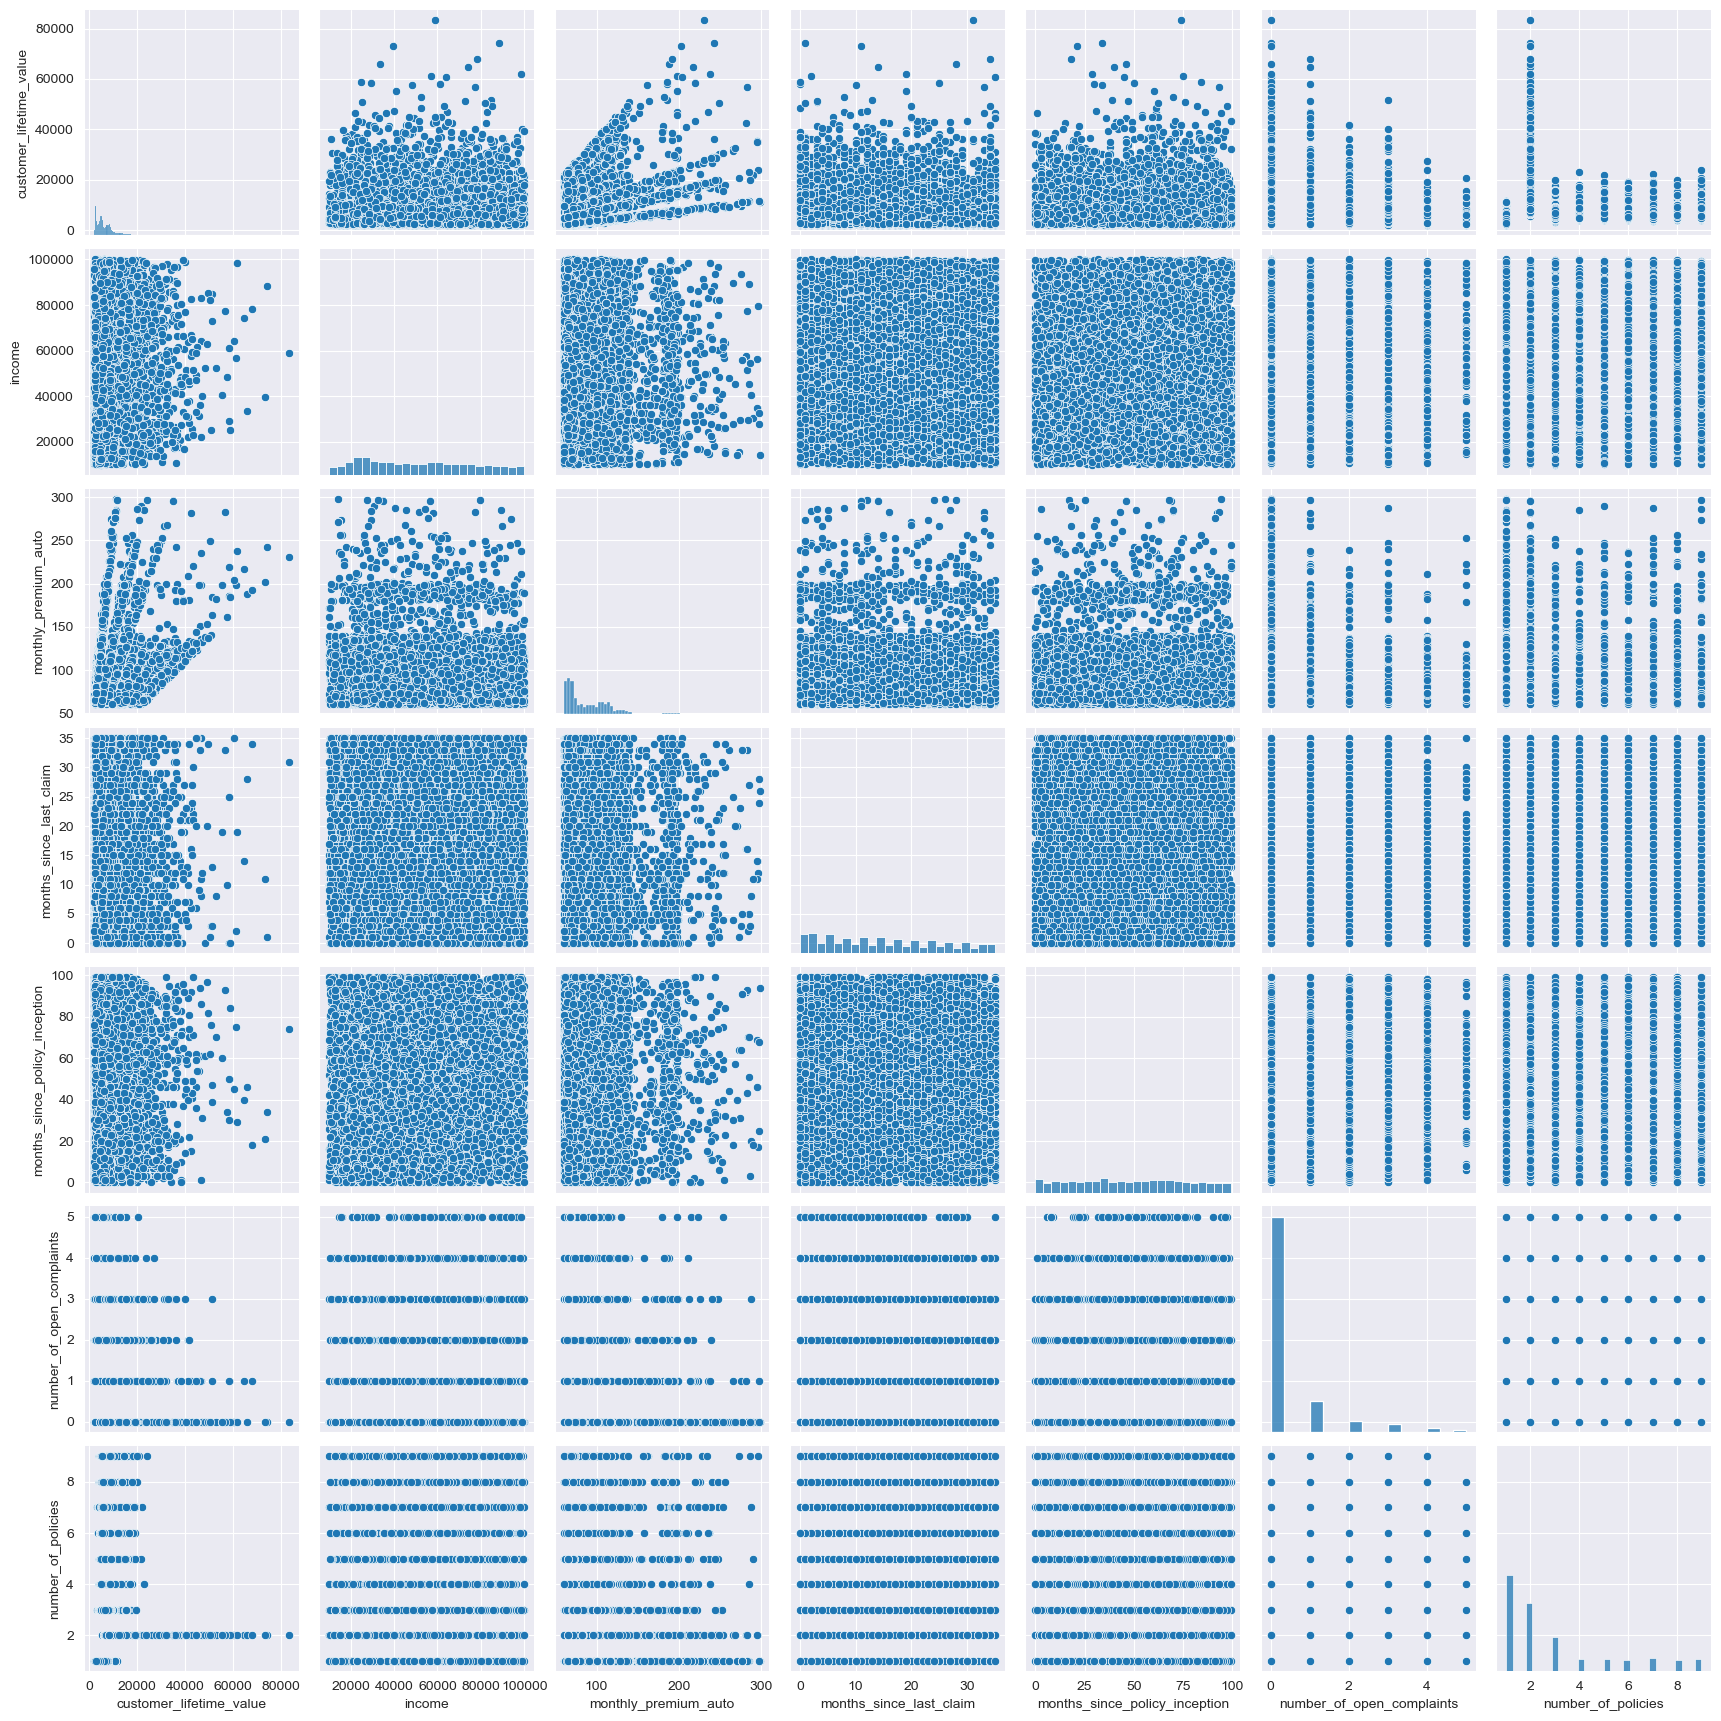

In [4]:
# use pairplot to find correclated features
sns.pairplot(df_num)

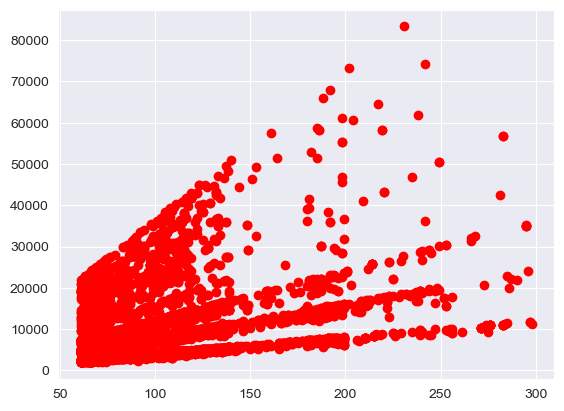

In [5]:
# plot the most correlated features against each otherS
plt.scatter(x=df_num["monthly_premium_auto"], y=df_num["customer_lifetime_value"], c="r")

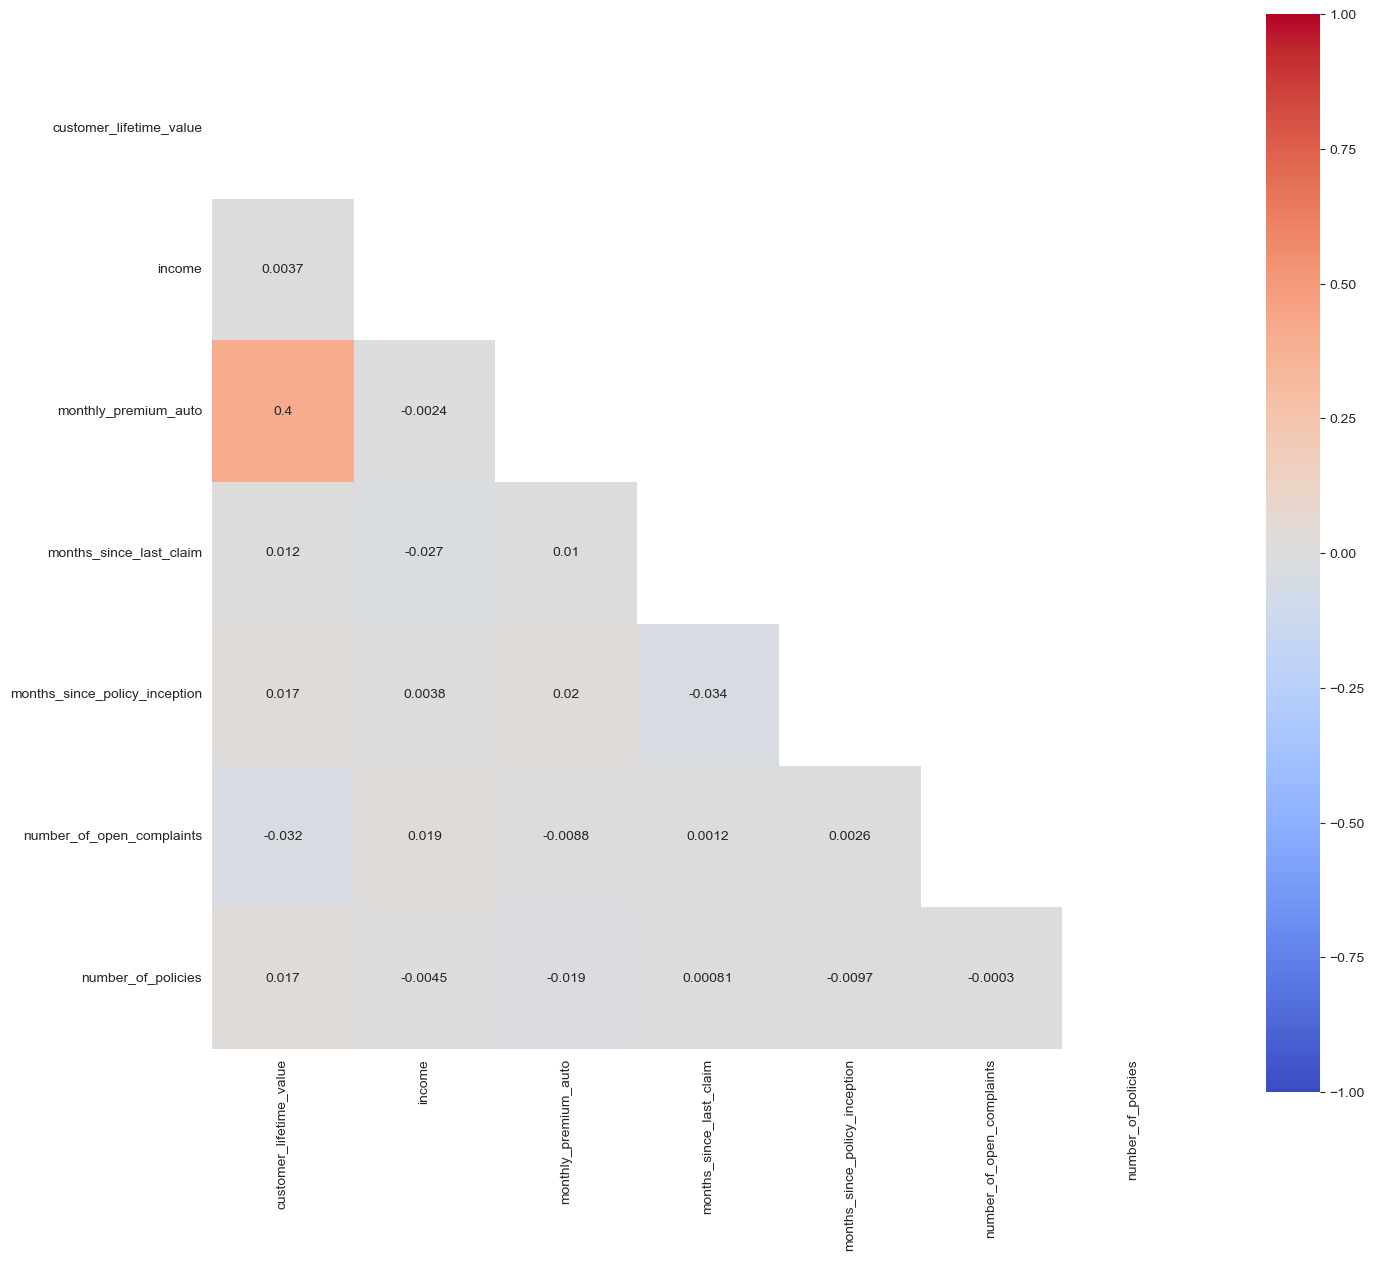

In [6]:
# determine correlation matrix and plot correlation heatmap
corr = df_num.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True # trick to filter out the upper-right triangle, which is redundant due to symmetry
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 14))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

In [7]:
#print(df_num.columns)
# kick out any highly correlated features
CORR_THRESH = 0.80
corr_matrix = df_num.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
corrd_cols = [column for column in upper_triangle.columns if any(upper_triangle[column] > CORR_THRESH)]
df_num.drop(corrd_cols,axis=1,inplace=True)
#print(df_num.columns)

array([[<AxesSubplot:title={'center':'customer_lifetime_value'}>,
        <AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'monthly_premium_auto'}>],
       [<AxesSubplot:title={'center':'months_since_last_claim'}>,
        <AxesSubplot:title={'center':'months_since_policy_inception'}>,
        <AxesSubplot:title={'center':'number_of_open_complaints'}>],
       [<AxesSubplot:title={'center':'number_of_policies'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

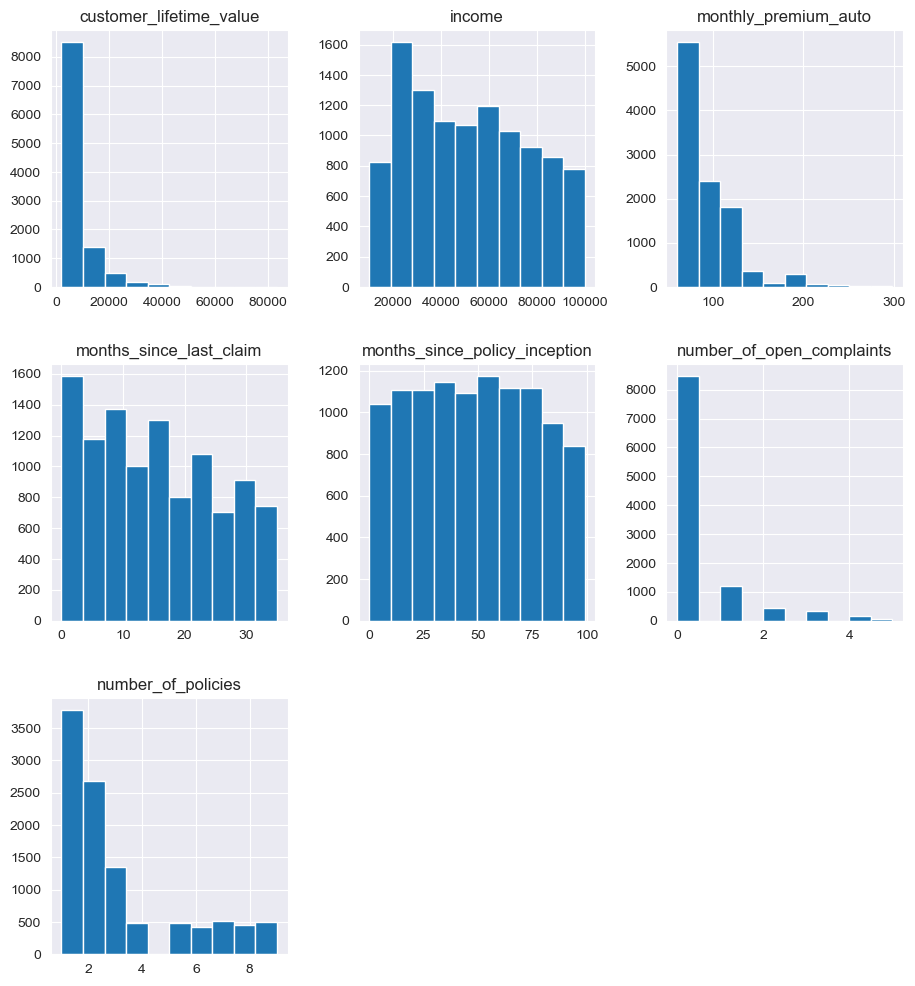

In [8]:
# plot histplots of the numerical data
df_num.hist(figsize=(11,12))

<AxesSubplot:xlabel='monthly_premium_auto', ylabel='Count'>

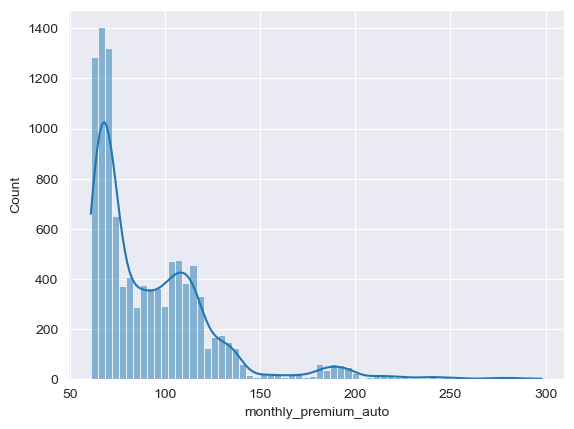

In [9]:
# monthly premium auto is scewed to the left
#sns.histplot(df_num["income"], kde=1)
sns.histplot(df_num["monthly_premium_auto"], kde=1)

In [10]:
# one-hot encode the categorical features
cols_to_dummify = df_cat.columns
df_dums = pd.DataFrame()
for i, col in enumerate(cols_to_dummify):
    df_dummies = pd.get_dummies(df_cat[col], drop_first=1)
    # concatenate the original dataframe with the dummy variables
    df_dums = pd.concat([df_dums, df_dummies], axis=1)

# 1. X-y split

In [34]:
from scipy.stats import zscore

In [35]:
# filter the dataframe to remove the outliers
def remove_outliers(num_df):
    z = num_df.apply(zscore)
    threshold = 3
    num_df = num_df[(z < threshold).all(axis=1)]
    return num_df

In [74]:
# how to get the same length for both numericalX and categoricalX?
remove_outliers(numericalX).info()
categoricalX.iloc[remove_outliers(numericalX).index].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10009 entries, 0 to 10688
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   Unnamed: 0                     10009 non-null  int64
 1   customer_lifetime_value        10009 non-null  int64
 2   income                         10009 non-null  int64
 3   monthly_premium_auto           10009 non-null  int64
 4   months_since_last_claim        10009 non-null  int64
 5   months_since_policy_inception  10009 non-null  int64
 6   number_of_open_complaints      10009 non-null  int64
 7   number_of_policies             10009 non-null  int64
dtypes: int64(8)
memory usage: 703.8 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10009 entries, 0 to 10688
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Unnamed: 0     10009 non-null  int64
 1   coverage       10009 non-null  i

In [88]:
# load the data with dummies and ordinally encoded categorical data and then load the numerical data
# define numerical and categorical Xs and target feature y
categoricalX = pd.read_csv("dum_df.csv")
numericalX = pd.read_csv("num_df.csv").drop("total_claim_amount", axis=1)

X = pd.concat([categoricalX.iloc[remove_outliers(numericalX).index], remove_outliers(numericalX[numericalX.columns])], axis=1)
y = df.iloc[remove_outliers(numericalX).index]["total_claim_amount"]

In [20]:
X.isna().any()
# no need to drop anything

Unnamed: 0                       False
coverage                         False
education                        False
vehicle_size                     False
east                             False
north west                       False
west region                      False
yes                              False
jan                              False
employed                         False
medical leave                    False
retired                          False
unemployed                       False
m                                False
suburban                         False
urban                            False
married                          False
single                           False
personal auto                    False
special auto                     False
corporate l2                     False
corporate l3                     False
personal l1                      False
personal l2                      False
personal l3                      False
special l1               

# 2. Test - train split

In [90]:
RAND_STATE = 34 # for reproducible shuffling
TT_RATIO = 0.3 # test/train

In [91]:
# test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train.head(10)

,coverage,education,vehicle_size,east,north west,west region,yes,jan,employed,medical leave,...,sports car,suv,two-door car,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
9491,0,0,1,0,0,1,0,0,1,0,...,0,0,0,5414,26893,68,1,31,0,5
9442,0,1,0,0,0,0,0,0,0,0,...,0,0,1,6826,20763,68,13,26,0,2
4279,0,3,1,1,0,0,0,1,1,0,...,0,0,0,2842,43793,71,8,31,0,1
8464,0,0,0,0,0,0,0,0,1,0,...,0,1,0,4272,81132,107,19,52,0,1
5703,0,0,1,0,0,1,0,0,0,0,...,0,0,1,20604,89454,72,8,61,1,2
8267,1,1,1,0,0,0,0,1,1,0,...,0,0,1,5358,83771,133,26,18,0,1
8470,0,0,1,0,0,0,1,1,0,0,...,0,0,0,2397,22283,65,16,93,0,1
2759,0,1,1,0,0,0,0,0,1,0,...,1,0,0,4538,82297,116,24,62,0,1
8654,0,0,1,0,0,0,0,1,1,0,...,0,1,0,13464,83392,112,20,34,0,2
6113,1,1,1,0,0,1,0,1,1,0,...,0,0,0,6186,88375,77,23,11,0,3


# 3. Standardize data

In [92]:
from sklearn.preprocessing import StandardScaler

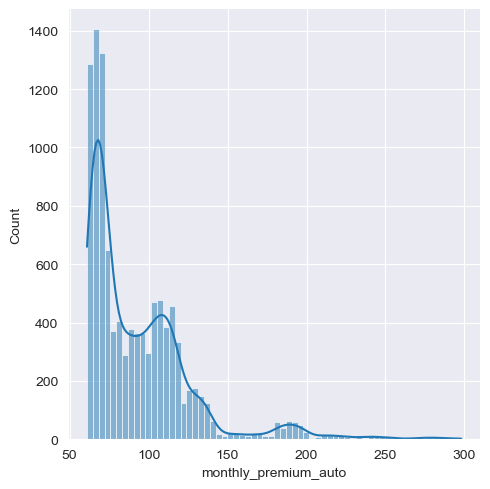

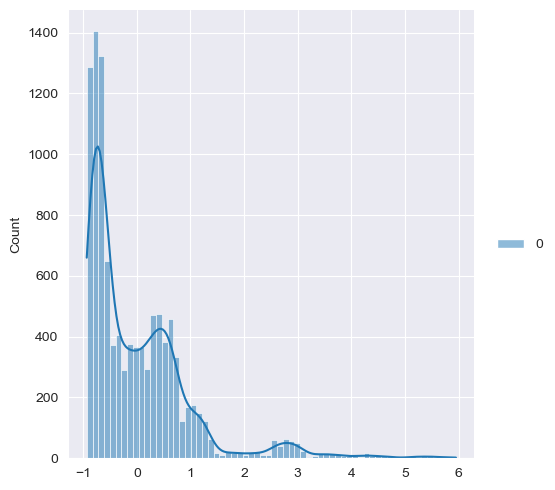

In [93]:
# apply the StandardScaler to scale the distributions
ss = StandardScaler()
monthly_premium_transformed = ss.fit_transform(numericalX["monthly_premium_auto"].to_numpy().reshape(-1,1))

# original distribution
sns.displot(numericalX["monthly_premium_auto"], kde=1)
# normalized distribution done with StandardScaler
sns.displot(monthly_premium_transformed, kde=1)

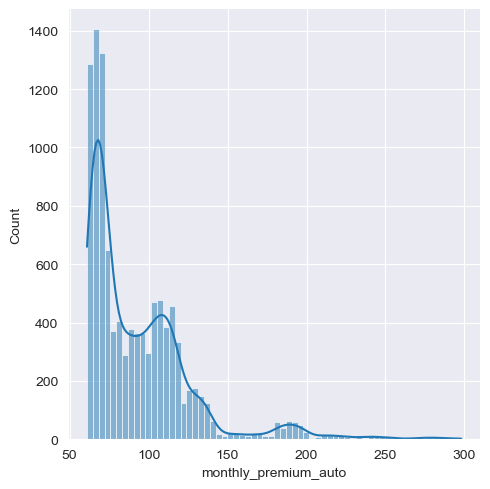

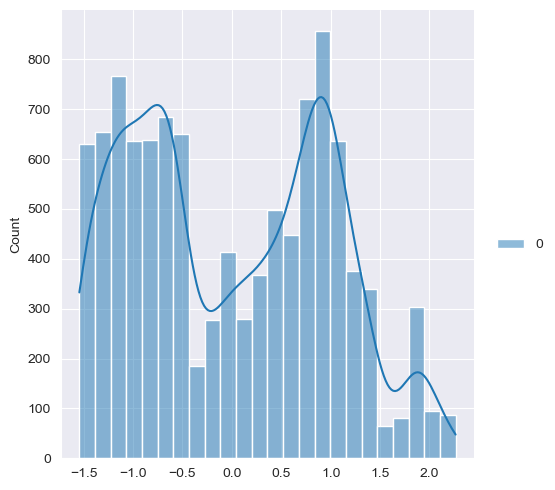

In [94]:
# apply the PowerTransformer to scale the distributions
pt = PowerTransformer()
monthly_premium_transformed = pt.fit_transform(df_num['monthly_premium_auto'].to_numpy().reshape(-1,1))

# original distribution
sns.displot(numericalX["monthly_premium_auto"], kde=1)
# normalized and normally transformed distribution done with PowerTransform
sns.displot(monthly_premium_transformed, kde=1)

In [95]:
print("the parameters used to transform monthly_premium_transformed (pt) are", pt.get_params(), "\nlambdas:" , pt.lambdas_)
# parameter used in the power transformation

print("the parameters used to transform monthly_premium_transformed (ss) are", ss.get_params())

the parameters used to transform monthly_premium_transformed (pt) are {'copy': True, 'method': 'yeo-johnson', 'standardize': True} 
lambdas: [-1.48520773]
the parameters used to transform monthly_premium_transformed (ss) are {'copy': True, 'with_mean': True, 'with_std': True}


In [97]:
ss = ColumnTransformer([("ss", ss, list(numericalX.columns))],
                        remainder='drop',verbose_feature_names_out=True,verbose=True).fit(X_train)
X_train_ss = pd.DataFrame(ss.fit_transform(X_train), columns=ss.get_feature_names_out())
X_train_ss

[ColumnTransformer] ............ (1 of 1) Processing ss, total=   0.0s
[ColumnTransformer] ............ (1 of 1) Processing ss, total=   0.0s


,ss__customer_lifetime_value,ss__income,ss__monthly_premium_auto,ss__months_since_last_claim,ss__months_since_policy_inception,ss__number_of_open_complaints,ss__number_of_policies
0,-0.367573,-1.001286,-0.785468,-1.403183,-0.609975,-0.430771,0.833654
1,-0.079279,-1.248185,-0.785468,-0.213134,-0.787855,-0.430771,-0.415134
2,-0.892708,-0.320602,-0.676111,-0.708988,-0.609975,-0.430771,-0.831396
3,-0.600739,1.183308,0.636182,0.381891,0.137119,-0.430771,-0.831396
4,2.733830,1.518495,-0.639658,-0.708988,0.457303,0.999553,-0.415134
...,...,...,...,...,...,...,...
7001,-1.031546,-0.527385,-0.858373,0.282720,1.666884,2.429877,-0.831396
7002,0.563869,0.900683,-0.967731,0.877745,-0.859007,-0.430771,-0.415134
7003,-0.719364,-0.586069,0.125846,1.472770,1.346701,-0.430771,-0.831396
7004,-0.422291,1.691606,-0.931279,1.869453,-0.859007,-0.430771,0.001129


In [98]:
# using the ColumnTransformer to transform the numerical columns with the PowerTransformer
ct = ColumnTransformer([("pt", pt, list(numericalX.columns))],
                        remainder='drop',verbose_feature_names_out=True,verbose=True).fit(X_train)
X_train_ct = pd.DataFrame(ct.transform(X_train),columns=ct.get_feature_names_out())
X_test_ct = pd.DataFrame(ct.transform(X_test),columns=ct.get_feature_names_out())

[ColumnTransformer] ............ (1 of 1) Processing pt, total=   0.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


# 4. Apply linear regression

## 4.1 OLS

In [30]:
X_train_const_ct = sm.add_constant(X_train_ct.to_numpy()) # adding a constant

model = sm.OLS(y_train, X_train_const_ct).fit()
# predictions_train = model.predict(X_train_const_ct)

X_test_const_ct = sm.add_constant(X_test_ct) # adding a constant
predictions_test = model.predict(X_test_const_ct)
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     490.3
Date:                Tue, 31 Jan 2023   Prob (F-statistic):               0.00
Time:                        17:47:41   Log-Likelihood:                -51659.
No. Observations:                7482   AIC:                         1.033e+05
Df Residuals:                    7474   BIC:                         1.034e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        435.8295      2.790    156.232      0.0

## 3.2 SciKit Learn

In [31]:
model=LinearRegression()    # model
model.fit(X_train_ct, y_train)   # model train

LinearRegression()

# 5. Model interpretation

In [32]:
model.coef_

array([ -0.44731571, -33.2628964 , 160.19471155,   3.25267606,
         1.10130638,  -2.35453312,  -1.30344579])

In [37]:
model.intercept_

435.8294573643475

In [38]:
y_pred = pd.DataFrame(model.predict(X_test_ct),columns = ['target_d'] )      # model prediction
y_pred_train =  pd.DataFrame(model.predict(X_train_ct),columns = ['target_d'])

In [39]:
y_pred

,target_d
0,611.378036
1,568.939940
2,567.307900
3,251.671241
4,377.884308
...,...
3202,256.384584
3203,385.643063
3204,435.298281
3205,323.939043


In [40]:
y_pred_train

,target_d
0,189.518733
1,289.692523
2,416.203846
3,250.059554
4,547.254150
...,...
7477,533.274615
7478,593.719913
7479,194.714282
7480,501.805809
